Manifold methods of the HR Predictive data
=========

Igor Marfin <igor.marfin@unister.de> 


-----------


Note that the purpose of the Manifold Learning Methods is to find a low-dimensional representation of the data  in which the distances respect well the distances in the original high-dimensional space.




## Initialization
---------------------------------


One needs to *import* properly defined modules to make this analysis.  First, we would like to make automatic
numbering the sections.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


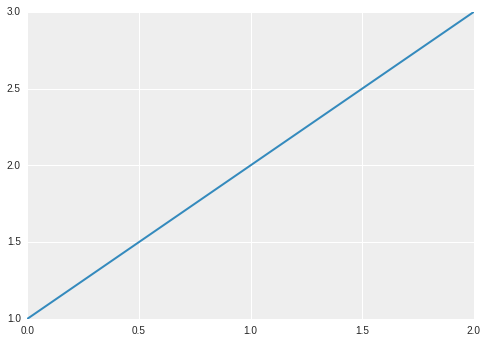

In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline


import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl


# a plotter module
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd

from Dataframe import Dataframe

# Imputer
import DataFrameImputer # my own imputer

# Transformers
import Normalizer # my own transformer
from sklearn import preprocessing # a set of transformers from sklearn

# To create Pipelines of the transformers
from sklearn.pipeline import Pipeline,FeatureUnion
from TransformWrapper import TransformWrapperLambda, TransformWrapperTransformer

# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )



prefix='HR_predictive_'
plots_dir = 'plots/'

ion()

# test plotting style'
from pylab import *
plot([1,2,3])
show()


import warnings
warnings.filterwarnings("ignore", category=UserWarning)




Pipelines of the transformers
----------------------------------



In [2]:
from  copy import copy,deepcopy

total_price_pipe =  Pipeline([
            ('abs',TransformWrapperLambda(lambda x:  float(x) if x >0. else 0.)),
            ('std',preprocessing.StandardScaler())
        ]) # our target

label_pipe=Pipeline([
            ('lb',TransformWrapperTransformer(preprocessing.LabelEncoder())),
            ('float',TransformWrapperLambda(lambda x: float(x))),
            ('std',preprocessing.StandardScaler())
        ]) # transformers pipe to transform labels

numeric_float_pipe=Pipeline([
            ('abs',TransformWrapperLambda(lambda x:  float(x) if x >0. else 0.)),            
            ('std',preprocessing.StandardScaler())
        ]) # transformer for numeric data


p_status_pipe = Pipeline([
            ('bit_mask_int',TransformWrapperLambda(lambda x: int(str(x)[:4],2))),           # first 4 bits
            ('float',TransformWrapperLambda(lambda x: float(x))),          
            ('std',preprocessing.StandardScaler())
        ]) # transformer for numeric data

p_kunde_comp_pipe = Pipeline([
            ('bit_mask_int',TransformWrapperLambda(lambda x: int(str(x)[:3],2))),           # first 3 bits
            ('float',TransformWrapperLambda(lambda x: float(x))),          
            ('std',preprocessing.StandardScaler())
        ]) # transformer for numeric data

booking_date_pipe = Pipeline([
        ('month',TransformWrapperLambda(lambda x: str(x)[2:5])),   
        ('lb',TransformWrapperTransformer(preprocessing.LabelEncoder())),
        ('float',TransformWrapperLambda(lambda x: float(x))),          
        ('std',preprocessing.StandardScaler())
        ])


features = [        
   
        # should we transform our target?
        #('total_price', total_price_pipe), # our target 
        ('total_price', None), # our target 
    
        # old approach: 'p_status' and Kunde_comp are labels --> tranform them as labels
        #('p_status',deepcopy(label_pipe)), # a label
        #('Kunde_comp',deepcopy(label_pipe)), # a label
        ('p_status',deepcopy(p_status_pipe)), # a bit-mask
        ('Kunde_comp',deepcopy(p_kunde_comp_pipe)), # a bit-mask        
        ('s_anrede',deepcopy(label_pipe)), # a categorical numerical value
        ('portal',deepcopy(label_pipe)), # !!!         
        ('s_title',deepcopy(label_pipe)), # !!! 
        ('booking_date',deepcopy(booking_date_pipe)), # !!! 

       
    
    
        # these labels are possible to be included only after imputting missing Data! 
        #('reise_land',deepcopy(label_pipe)), # !!! 
        #('city_std',deepcopy(label_pipe)), # !!! 
        
     
]

Reading training data
----------------------------------

In [3]:
# -*- coding: utf-8 -*-


# 1. a place, where data are stored  and a name of the training set
data_dir = 'data/'
file_for_training = 'HR_Guschein_Booker_150518' 


# 2. reading the csv file and creating the dataframe
# also, we want to know CPU time of this operation
%time df=Dataframe(data_dir+file_for_training+'.csv',features)



'''
# 3. finding fake data:
    with 'total_price'<1Euro OR 'book_duration'<0 days OR 'reise_dauer'<0 days OR 'Buch_anzahl'<1 
     OR 'no_of_persons<1'
'''

criteria_index=df.dataset.loc[
    (df.dataset['total_price'] < 1) |
    (df.dataset['book_duration'] < 0) |
    (df.dataset['reise_dauer'] < 0) |
    (df.dataset['Buch_anzahl'] < 1) |
    (df.dataset['no_of_persons'] < 1)     
    ].index


fake_data=df.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "fake data" criteria'%len(fake_data)
print '<>'*30,'\n\n'

if (len(fake_data))>0:    

    # 3.2 droping fake data from the original dataframes
    df.dataset=df.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for final stage'%len(df.dataset)
print '<>'*30,'\n\n'
    
    
# 4. doing replacement only string fields
for column in df.dataset.columns:
    if ( 
            pd.isnull(df.dataset[column]).any() and 
            df.dataset[column].dtype == dtype('object') # string's type is 'object'
        ): 
            df.dataset[column].fillna('UNKNOWN', inplace=True)


#5. filling missed (NaB) data: only numerical NaN data will be imputted
print 'Does age field contains NaNs?', pd.isnull(df.dataset['age']).any()
df.dataset = DataFrameImputer.DataFrameImputer().fit(df.dataset).transform(df.dataset)
print 'Does age field contains NaNs after imputting?', pd.isnull(df.dataset['age']).any()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.2 ms


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 0 entries which are satisfied to "fake data" criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 6064 entries which are passed for final stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 


Does age field contains NaNs? True
Does age field contains NaNs after imputting? False


Transformation of the training data
---------------------------------------

In [5]:
#Transformation of the dataset
update = False
if not(os.path.exists(data_dir+file_for_training+'_transformed'+'.csv')) or update:    
    %time df.transform_dataframe() 
    df.datasettransformed.to_csv(data_dir+file_for_training+'_transformed'+'.csv', sep=',',index=False,encoding='utf-8')
else:
    print 'reading ....'
    df.datasettransformed= pd.read_csv(data_dir+file_for_training+'_transformed'+'.csv',na_values=[' ',''],keep_default_na = True,sep=",",encoding='utf-8')
    
    
#print first 3 entries
print len(df.datasettransformed)
print df.datasettransformed.head(3)

reading ....
6064
   ﻿"single_price"  book_duration  booking_date  p_status  Kunde_comp  \
0      1455.576667           1325     -0.932324 -0.598345   -0.308221   
1       972.333333            881     -1.558450 -0.598345   -0.308221   
2       987.236667            777     -1.558450  1.660206   -0.308221   

    orderid source  CustomerID    portal   Basket_comp   s_title  s_anrede  \
0  30149840     UP     6523830  0.994075  100010.00000  5.359617 -1.281889   
1   7014547     FK   223422870  0.036440  234120.32197  5.359617  1.635497   
2  30514867     UP     6124506 -0.681786      10.00000 -0.186581  0.176804   

   ClusterID       age gutscheinnutzung  total_price  reise_dauer  \
0        881 -0.792459             OHNE      8733.46     0.073181   
1       4086  1.864365             NEIN      5834.00     0.287707   
2       4203  0.955452             OHNE      5923.42     0.173293   

   no_of_persons     stars  Buch_anzahl  
0       0.034829  0.183229     0.068956  
1       0.25111

### Reading the test data

--------------------------------


In [6]:
# -*- coding: utf-8 -*-


# 1. a place, where data are stored  and a name of the testing set
data_dir = 'data/'
file_for_testing = 'Nur_HR_Kunden_150518'


# 2. reading the csv file and creating the dataframe
# also, we want to know CPU time of this operation
%time df_test=Dataframe(data_dir+file_for_testing+'.csv',features)



'''
# 3. finding fake data:
    with 'total_price'<1Euro OR 'book_duration'<0 days OR 'reise_dauer'<0 days OR 'Buch_anzahl'<1 
     OR 'no_of_persons<1'
'''

criteria_index=df_test.dataset.loc[
    (df_test.dataset['total_price'] < 1) |
    (df_test.dataset['book_duration'] < 0) |
    (df_test.dataset['reise_dauer'] < 0) |
    (df_test.dataset['Buch_anzahl'] < 1) |
    (df_test.dataset['no_of_persons'] < 1)     
    ].index


fake_data=df_test.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "fake data" criteria'%len(fake_data)
print '<>'*30,'\n\n'

if (len(fake_data))>0:    

    # 3.2 droping fake data from the original dataframes
    df_test.dataset=df_test.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for the next stage'%len(df_test.dataset)
print '<>'*30,'\n\n'
    

# 3.2 here is an additional preselection: 
'''         droping all customers which are outliers:
                who spending lie in the tails of the distributions of 'total_price' -->
                <= 10% or >=90%
                
             Why are we doing that?    
             We think that people, whose 'total_price' is too low at this moment, have bought some products
             occassionaly. It was more likely the first-last buying.
             
             Also people who spent too much money to this moment, perhaps, have 'performed'  all their hollidays planned in
             this year.

'''


min_10=df_test.dataset['total_price'].describe(percentiles=[.05,.1,.25,.5,.75,.90,.95])['10%']
max_90=df_test.dataset['total_price'].describe(percentiles=[.05,.1,.25,.5,.75,.90,.95])['90%']

criteria_index=df_test.dataset.loc[
    (df_test.dataset['total_price'] < min_10) | 
    (df_test.dataset['total_price'] > max_90) 
    ].index


outliers=df_test.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "outlier"  criteria'%len(outliers)
print '<>'*30,'\n\n'

if (len(outliers))>0:

    # drop fake data from the original dataframes
    df_test.dataset=df_test.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for the next stage'%len(df_test.dataset)
print '<>'*30,'\n\n'
    
    
# 4. doing replacement only string fields
for column in df_test.dataset.columns:
    if ( 
            pd.isnull(df_test.dataset[column]).any() and 
            df_test.dataset[column].dtype == dtype('object') # string's type is 'object'
        ): df_test.dataset[column].fillna('UNKNOWN', inplace=True)


#5. filling missed (NaB) data: only numerical NaN data will be imputted
print 'Does age field contains NaNs?', pd.isnull(df_test.dataset['age']).any()
df_test.dataset = DataFrameImputer.DataFrameImputer().fit(df_test.dataset).transform(df_test.dataset)
print 'Does age field contains NaNs after imputting?', pd.isnull(df_test.dataset['age']).any()



CPU times: user 972 ms, sys: 172 ms, total: 1.14 s
Wall time: 1.14 s


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 1772 entries which are satisfied to "fake data" criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 465579 entries which are passed for the next stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 92219 entries which are satisfied to "outlier"  criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 373360 entries which are passed for the next stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 


Does age field contains NaNs? True
Does age field contains NaNs after imputting? False


In [7]:
#Transformation of the dataset 
# a single process --> too long 5 minutes 18 seconds (318 seconds) to process 500K entries,  we could implement multiprocessing
if not(os.path.exists(data_dir+file_for_testing+'_transformed'+'.csv')) or update:  
    %time df_test.transform_dataframe(doFit=False)
    df_test.datasettransformed.to_csv(data_dir+file_for_testing+'_transformed'+'.csv', sep=',',index=False,encoding='utf-8')
else:
    print 'reading...'
    df_test.datasettransformed= pd.read_csv(data_dir+file_for_testing+'_transformed'+'.csv',na_values=[' ',''],keep_default_na = True,sep=",",encoding='utf-8')


#print first 3 entries
print len(df_test.datasettransformed)
print df_test.datasettransformed.head(3)

reading...
373360
  ﻿"Kunde_type"  single_price  book_duration  booking_date  p_status  \
0         Hotel    189.126667            347      1.259120 -3.421533   
1         Hotel    129.000000              0      0.319930 -3.986171   
2         Hotel    288.543333           1004      0.632993 -3.421533   

   Kunde_comp   orderid source  CustomerID    portal    ...      s_title  \
0   -3.955153  28063384     UP     5932722  0.275849    ...    -0.186581   
1   -3.955153  27657272     UP     5655817  0.275849    ...    -0.186581   
2   -3.955153  29427328     UP     6764951  0.275849    ...    -0.186581   

   s_anrede  ClusterID       age  total_price  reise_dauer  no_of_persons  \
0  0.176804        490 -0.722543       567.38    -0.427379      -0.397747   
1 -1.281889        547 -1.841206       129.00    -0.413078      -0.451819   
2  0.176804        549 -1.281874       865.63    -0.312966      -0.235531   

      stars  Buch_anzahl  FL_check  
0 -0.392097    -0.164083         0  
1  0.

### Definition of the `X`: the n-dimensional feature space


In [8]:
# the features of data

train_cols=[  feature[0] for feature in features if feature[0] != 'total_price']
X_train = df.datasettransformed[train_cols].as_matrix()

# randomly pick up the same number as in the train case of 'total_price' values 
X_test=df_test.datasettransformed.loc[:,train_cols].as_matrix()

print 'Test size {0:d}'.format(X_test.shape[0])
print 'Train size {0:d}'.format(X_train.shape[0])


Test size 373360
Train size 6064


### Dimensionality Reduction: PCA

-----------------------------------------

Dimensionality reduction is the task of deriving a set of new artificial features that is smaller than the original feature set while retaining most of the variance of the original data. Here we'll use a common but powerful dimensionality reduction technique called Principal Component Analysis (PCA). 

In [9]:
from sklearn import manifold
from sklearn.decomposition import PCA

# we want to test the following variables
what_to_test=['p_status','Kunde_comp','booking_date','portal']
what_to_test=map(lambda x: train_cols.index(x),what_to_test)
what_to_test

X_train=np.array([X_train.T[i] for i in what_to_test]).T
X_test=np.array([X_test.T[i] for i in what_to_test]).T



pca_train = PCA(n_components=4, whiten=True)
pca_test = PCA(n_components=4, whiten=True)
%time pca_train.fit(X_train)
%time pca_test.fit(X_test)


CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 118 ms
CPU times: user 56 ms, sys: 20 ms, total: 76 ms
Wall time: 78.3 ms


PCA(copy=True, n_components=4, whiten=True)

Before we do selection, we want to compare distribution of train and test data in the `p_status` and `Kunde_comp` plane

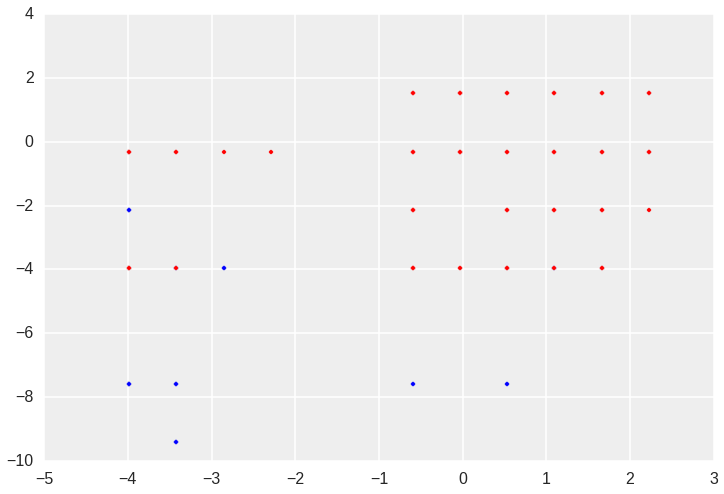

In [10]:
# before pca transforming, plot the scratter plots
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))
axes.scatter(X_test[:, 0], X_test[:, 1], c='b', cmap=plt.cm.Spectral)
axes.scatter(X_train[:, 0], X_train[:, 1], c='r', cmap=plt.cm.Spectral)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 841 µs
CPU times: user 40 ms, sys: 16 ms, total: 56 ms
Wall time: 55 ms


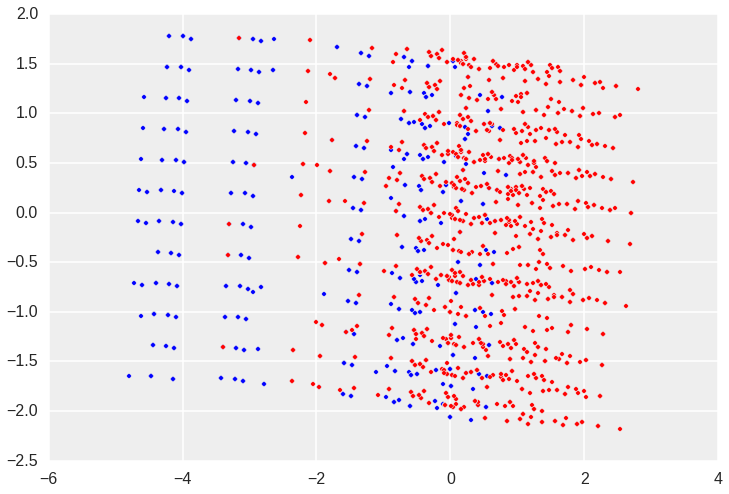

In [11]:
# after pca transfrorming, plot the scratter plots
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))

%time Y_train =pca_train.transform(X_train) 
#%time Y_test = pca_train.transform(X_test)
%time Y_test = pca_train.transform(X_test)
axes.scatter(Y_test[:, 0], Y_test[:, 1], c='b', cmap=plt.cm.Spectral)
axes.scatter(Y_train[:, 0], Y_train[:, 1], c='r', cmap=plt.cm.Spectral)


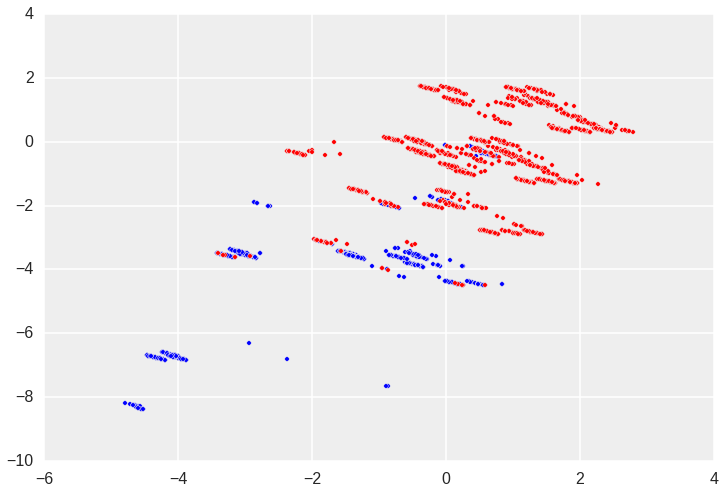

In [12]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))
axes.scatter(Y_test[:, 0], Y_test[:, 2], c='b', cmap=plt.cm.Spectral)
axes.scatter(Y_train[:, 0], Y_train[:, 2], c='r', cmap=plt.cm.Spectral)


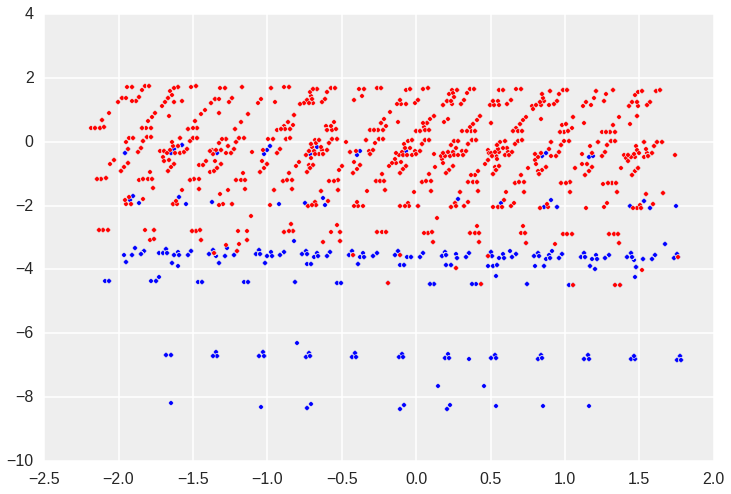

In [13]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))
axes.scatter(Y_test[:, 1], Y_test[:, 2], c='b', cmap=plt.cm.Spectral)
axes.scatter(Y_train[:, 1], Y_train[:, 2], c='r', cmap=plt.cm.Spectral)

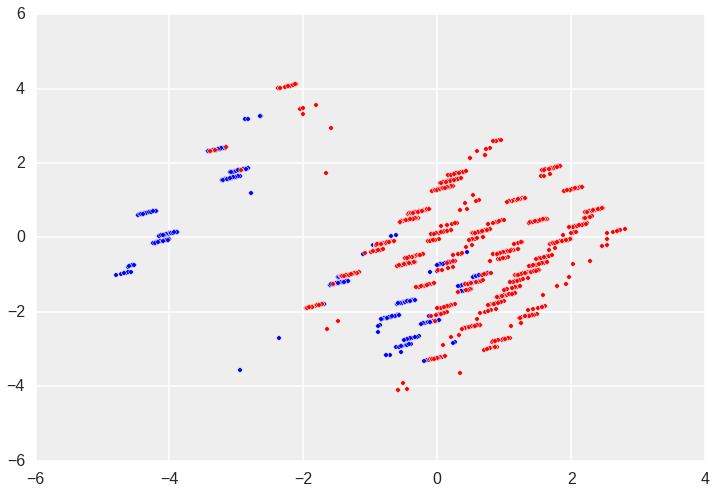

In [14]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))
axes.scatter(Y_test[:, 0], Y_test[:, 3], c='b', cmap=plt.cm.Spectral)
axes.scatter(Y_train[:, 0], Y_train[:, 3], c='r', cmap=plt.cm.Spectral)

Clustering
---------------------------
-------------------------------------


Clustering is the task of gathering samples into groups of similar samples according to some predefined similarity or dissimilarity measure (such as the Euclidean distance). 
We use one of the simplest clustering algorithms, K-means. This is an iterative algorithm which searches for a cluster center such that the distance from each point to the center of the cluster is minimizied. 


In [15]:
from sklearn.cluster import KMeans
from numpy.random import RandomState
rng = RandomState(42)

# test two clusters: in 'original 4-dim and 'pca-transformed' 2-dim spaces
kmeans_orig = KMeans(n_clusters=1, random_state=rng)
kmeans_pca = KMeans(n_clusters=1, random_state=rng)


kmeans_orig.fit(X_train)
kmeans_pca.fit(Y_train)



KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=1, n_init=10,
    n_jobs=1, precompute_distances='auto',
    random_state=<mtrand.RandomState object at 0xaac3340c>, tol=0.0001,
    verbose=0)

In [17]:

# get distances of test data to the center of the cluster based on the train data
d_orig = kmeans_orig.transform(X_test)[:,0]
d_pca = kmeans_pca.transform(Y_test)[:,0]


file_for_results='predicted_Cluster'
how_many_best_customers = 100000


# first 100K closest customers are 
ind_orig = np.argsort(d_orig)[:][:how_many_best_customers]
ind_pca = np.argsort(d_pca)[:][:how_many_best_customers]

selectd_orig=df_test.datasettransformed.loc[ind_orig
                                      ,['ClusterID','total_price']]
selectd_pca=df_test.datasettransformed.loc[ind_pca
                                      ,['ClusterID','total_price']]

Printing some statistics of the selected customers ...

In [18]:
# print results
selectd_orig.describe()


ClusterID    total_price
count   100000.000000  100000.000000
mean   3929979.328870     365.210474
std    2267917.658444     217.441411
min        490.000000      74.000000
25%    1984628.250000     178.000000
50%    3865484.000000     319.925000
75%    5886706.250000     525.467500
max    7921777.000000     867.720000

In [19]:
# print results
selectd_pca.describe()

ClusterID    total_price
count   100000.000000  100000.000000
mean   3979908.601010     363.266354
std    2244615.653574     217.352899
min        490.000000      74.000000
25%    2139787.500000     176.000000
50%    3945433.000000     317.280000
75%    5919814.000000     522.587750
max    7921753.000000     867.720000

Overlapping of the Cluster-selected 

In [20]:
# overlapping of the two selections
selectd_orig_clusterid =  selectd_orig['ClusterID'].as_matrix()
selectd_orig_clusterid = selectd_orig_clusterid.astype('int')

selectd_pca_clusterid =  selectd_pca['ClusterID'].as_matrix()
selectd_pca_clusterid = selectd_pca_clusterid.astype('int')
print 'Overlapping of two cluster predictions is ', \
float(np.intersect1d(selectd_orig_clusterid,selectd_pca_clusterid).shape[0])\
/max(len(selectd_orig_clusterid),len(selectd_pca_clusterid))



Overlapping of two cluster predictions is  0.7534


Save results 
----------------------

---------------------------

In [21]:
# save an 'original' result to the file 
cols_to_save=['total_price','ClusterID']
df_test.datasettransformed.loc[ind_orig,cols_to_save].to_csv(\
                                    data_dir+file_for_results+'_orig'+'.csv', sep=',',index=False,encoding='utf-8') 

# print a few customers 
df_test.datasettransformed.loc[ind_orig,cols_to_save].head(10)

total_price  ClusterID
147044       551.92    3141421
8398         405.68     255836
261677       787.40    5550272
187333       602.00    3963368
75960        824.75    1673805
233492       592.40    4910956
172273       565.00    3705702
92393        683.00    2014761
226353       474.00    4786440
280974       643.50    6019567

In [22]:
# save an 'pca' result to the file 
cols_to_save=['total_price','ClusterID']
df_test.datasettransformed.loc[ind_pca,cols_to_save].to_csv(\
                                    data_dir+file_for_results+'_pca'+'.csv', sep=',',index=False,encoding='utf-8') 


# print a few customers 
df_test.datasettransformed.loc[ind_pca,cols_to_save].head(10)

total_price  ClusterID
147044       551.92    3141421
8398         405.68     255836
261677       787.40    5550272
187333       602.00    3963368
172273       565.00    3705702
233492       592.40    4910956
227718       735.00    4811903
64528        770.00    1422674
192659       618.84    4052515
75960        824.75    1673805